Обучить AE собственной архитектуры на MNIST

Обучить VAE собственной архитектуры на MNIST

\* Обучить VAE с переносом стиля на MNIST (на вход декодеру подавать hidden с таргетным значением, чтобы можно было нарисовать заданную цифру в заданном стиле)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
transform = transforms.ToTensor()

mnist_data = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform)

data_loader = torch.utils.data.DataLoader(
    dataset=mnist_data,
    batch_size=64,
    shuffle=True)

### AE с линейными слоями

In [3]:
class AE_Linear(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=784, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=12),
            nn.ReLU(),
            nn.Linear(in_features=12, out_features=3)         
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 784),
            nn.Sigmoid()
        )
    def forward(self, x):
        # x -> 64, 784
        encoded = self.encoder(x) # -> 64, 3
        decoded = self.decoder(encoded) # -> 64, 784
        return decoded

In [4]:
model = AE_Linear()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=1e-3, 
    weight_decay=1e-5)

n_epochs = 5
outputs = []
for epoch in range(n_epochs):
    for (img, _) in data_loader:
        img = img.reshape(-1, 784)
        recon = model(img)
        loss = criterion(recon, img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch: {epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch: 1, Loss:0.0547
Epoch: 2, Loss:0.0418
Epoch: 3, Loss:0.0408
Epoch: 4, Loss:0.0351
Epoch: 5, Loss:0.0378


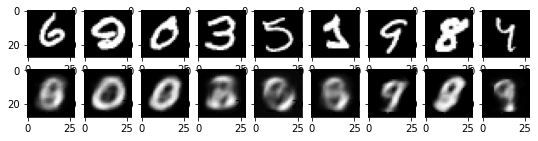

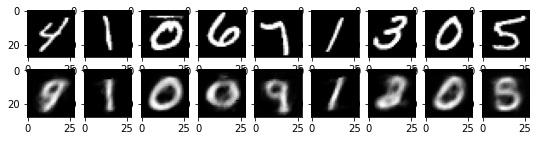

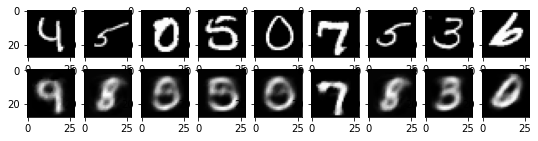

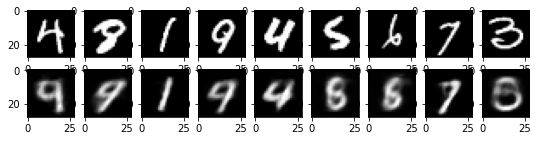

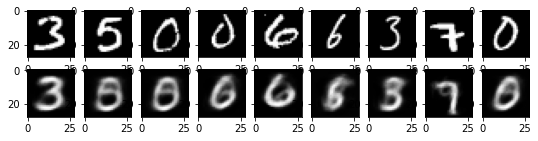

In [5]:
for k in range(n_epochs):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9:
            break
        plt.subplot(2, 9, i+1)
        item = item.reshape(-1, 28, 28)
        plt.imshow(item[0])
    for i, item in enumerate(recon):
        if i >= 9:
            break
        plt.subplot(2, 9, 9+i+1)
        item = item.reshape(-1, 28, 28)
        plt.imshow(item[0])

### AE со сверточными слоями

In [6]:
class AE_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=7),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.Sigmoid()
        )
    def forward(self, x):
        # x -> 64, 1, 28, 28 
        encoded = self.encoder(x) # -> 64, 64, 1, 1 
        decoded = self.decoder(encoded) # -> 64, 1, 28, 28 
        return decoded

In [7]:
model = AE_CNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=1e-3, 
    weight_decay=1e-5)

n_epochs = 5
outputs = []
for epoch in range(n_epochs):
    for (img, _) in data_loader:
        recon = model(img)
        loss = criterion(recon, img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch: {epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch: 1, Loss:0.0090
Epoch: 2, Loss:0.0047
Epoch: 3, Loss:0.0046
Epoch: 4, Loss:0.0029
Epoch: 5, Loss:0.0033


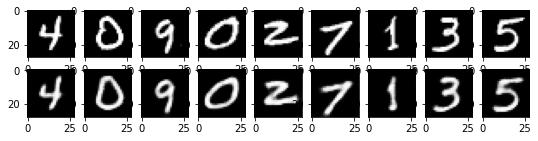

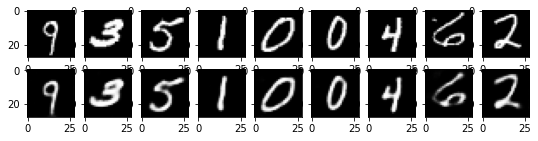

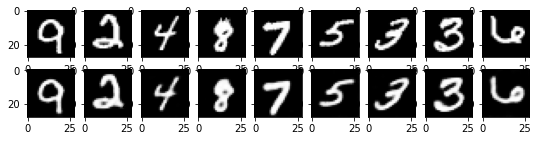

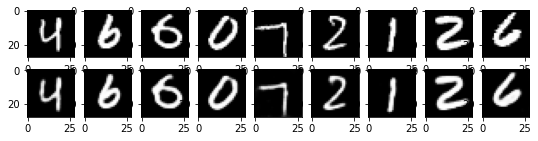

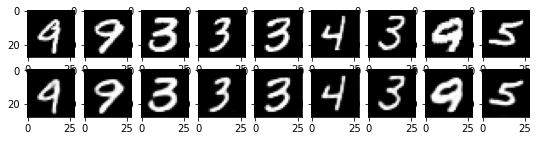

In [8]:
for k in range(n_epochs):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9:
            break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])
    for i, item in enumerate(recon):
        if i >= 9:
            break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0])

### VAE со сверточными слоями

In [9]:
class VAE_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.mu = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=7)
        )
        self.sigma = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=7)
        )
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=7)
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, stride=3),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=7),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
    def forward(self, x):
        # x -> 64, 1, 28, 28
        encoded = self.encoder(x) # -> 64, 64, 1, 1
        mu = self.mu(encoded)
        sigma = torch.exp(self.sigma(encoded))
        sample = mu + torch.normal(torch.zeros_like(sigma), torch.ones_like(sigma)) * sigma
        decoded = self.decoder(sample) # -> 64, 1, 28, 28
        return decoded

In [10]:
model = VAE_CNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=1e-3, 
    weight_decay=1e-5
)

n_epochs = 5
outputs = []
for epoch in range(n_epochs):
    for (img, _) in data_loader:
        recon = model(img)
        loss = criterion(recon, img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch: {epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch: 1, Loss:0.0226
Epoch: 2, Loss:0.0151
Epoch: 3, Loss:0.0086
Epoch: 4, Loss:0.0090
Epoch: 5, Loss:0.0085


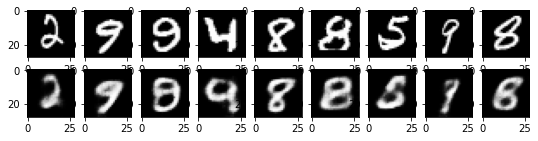

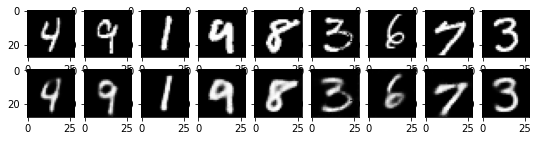

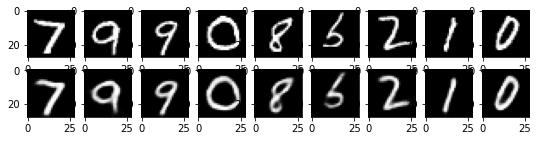

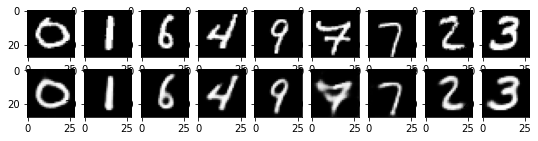

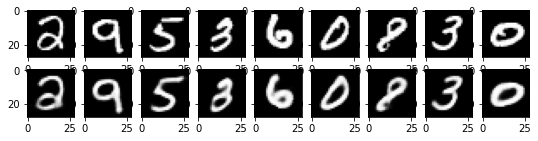

In [11]:
for k in range(n_epochs):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9:
            break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])
    for i, item in enumerate(recon):
        if i >= 9:
            break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0])